In [1]:
!pip install yfinance
!pip install requests --upgrade
!pip install xmltodict --upgrade
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


# **Data Extraction**

### **Python Libraries**

In [2]:
import yfinance
import datetime
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
from matplotlib.patches import Circle, Rectangle
from functools import partial
from scipy import stats
import requests
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.api import add_constant
from statsmodels.tools.eval_measures import meanabs, mse, rmse
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.stattools import pacf, acf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

### **Global Variables**

In [3]:
START = "2020-01-01"
END = "2025-07-31"

### **British Automobile Tickers**

<Axes: xlabel='Date'>

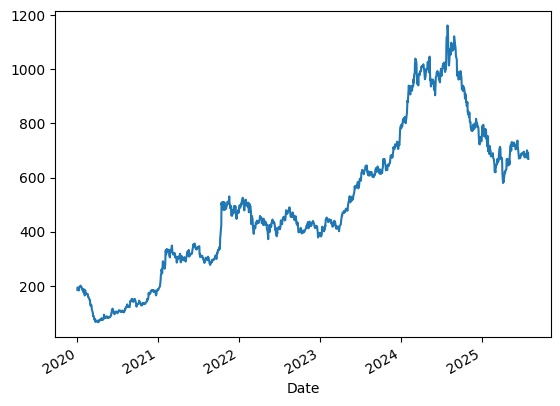

In [4]:
tata = 'TATAMOTORS.NS'
ticker = yfinance.Ticker(tata)
tata_close = ticker.history(start=START, end=END, auto_adjust=False)['Close']
tata_close.plot()

<Axes: xlabel='Date'>

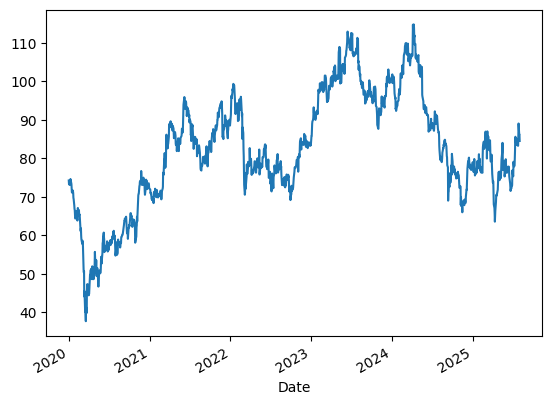

In [5]:
bmw = 'BMW.DE'
ticker = yfinance.Ticker(bmw)
bmw_close = ticker.history(start=START, end=END, auto_adjust=False)['Close']
bmw_close.plot()

<Axes: xlabel='Date'>

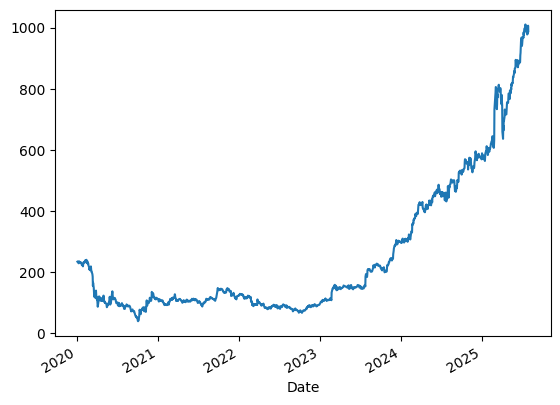

In [6]:
rrl = 'RR.L'
ticker = yfinance.Ticker(rrl)
rrl_close = ticker.history(start=START, end=END, auto_adjust=False)['Close']
rrl_close.plot()

###**Train-Test Split**

In [7]:
START = datetime.datetime(2020, 1, 1)
SPLIT1 = datetime.datetime(2024, 6, 1)
SPLIT2 = datetime.datetime(2025, 1, 1)
END = datetime.datetime(2025, 7, 31)

tata_base = tata_close.reset_index().copy()
bmw_base = bmw_close.reset_index().copy()
rrl_base = rrl_close.reset_index().copy()

tata_base['Date'] = pandas.to_datetime(tata_base.Date).dt.tz_localize(None)
bmw_base['Date'] = pandas.to_datetime(bmw_base.Date).dt.tz_localize(None)
rrl_base['Date'] = pandas.to_datetime(rrl_base.Date).dt.tz_localize(None)

tata_close = tata_base[tata_base.Date.between(START, SPLIT1)]
bmw_close = bmw_base[bmw_base.Date.between(START, SPLIT1)]
rrl_close = rrl_base[rrl_base.Date.between(START, SPLIT1)]

tata_close.set_index('Date', inplace=True)
bmw_close.set_index('Date', inplace=True)
rrl_close.set_index('Date', inplace=True)

tata_val = tata_base[tata_base.Date.between(SPLIT1, SPLIT2)]
bmw_val  = bmw_base[bmw_base.Date.between(SPLIT1, SPLIT2)]
rrl_val  = rrl_base[rrl_base.Date.between(SPLIT1, SPLIT2)]

tata_val.set_index('Date', inplace=True)
bmw_val.set_index('Date', inplace=True)
rrl_val.set_index('Date', inplace=True)

tata_test = tata_base[tata_base.Date.between(SPLIT2, END)]
bmw_test = bmw_base[bmw_base.Date.between(SPLIT2, END)]
rrl_test = rrl_base[rrl_base.Date.between(SPLIT2, END)]

tata_test.set_index('Date', inplace=True)
bmw_test.set_index('Date', inplace=True)
rrl_test.set_index('Date', inplace=True)

START = "2020-01-01"
END = "2024-06-01"

# **Data Quality Checks**

### **Global Variables**

In [8]:
TABLES = [(tata_close, 'TATA Shares'),
          (bmw_close, 'BMW Shares'),
          (rrl_close, 'Rolls-Royce Shares')]

### **Missing Values**

In [9]:
def NullsDecompose(tables):
  dt = datetime.datetime.strptime
  FORMAT = '%Y-%m-%d'
  COUNT = dt(END, FORMAT) - dt(START, FORMAT)
  COUNT = COUNT.days
  nulls = {'TABLES':[], 'COLUMNS':[], '% NULLS':[]}
  for table, name in tables:
    _table = table.reset_index()
    for col in [*_table]:
      base = _table[col]
      null_vals = COUNT-base[base.notnull()].count()
      nulls['% NULLS'].append(null_vals/COUNT)
      nulls['COLUMNS'].append(col)
      nulls['TABLES'].append(name)
  nulls = pandas.DataFrame.from_dict(nulls)
  return nulls.style.format({'% NULLS':'{:.0%}'})

NullsDecompose(TABLES)

,TABLES,COLUMNS,% NULLS
0,TATA Shares,Date,32%
1,TATA Shares,Close,32%
2,BMW Shares,Date,30%
3,BMW Shares,Close,30%
4,Rolls-Royce Shares,Date,31%
5,Rolls-Royce Shares,Close,31%


### **Duplicates**

In [10]:
def DuplicatesDecompose(tables):
  duplicates = {'TABLES':[], 'COLUMNS':[], '% DUPLICATES':[]}
  for table, name in tables:
      base = table.reset_index()['Date']
      COUNT = len(base)
      duplicates['% DUPLICATES'].append(base[base.duplicated()].count()/COUNT)
      duplicates['COLUMNS'].append('DATE')
      duplicates['TABLES'].append(name)
  duplicates = pandas.DataFrame.from_dict(duplicates)
  return duplicates.style.format({'% DUPLICATES':'{:.0%}'})

DuplicatesDecompose(TABLES)

,TABLES,COLUMNS,% DUPLICATES
0,TATA Shares,DATE,0%
1,BMW Shares,DATE,0%
2,Rolls-Royce Shares,DATE,0%


### **Timeliness**

In [11]:
def TimelinessDecompose(tables):
  untimely = {'TABLES':[], 'COLUMNS':[], '% UNTIMELY':[]}
  for table, name in tables:
      base = table.reset_index()['Date']
      COUNT = len(base)
      untimely['% UNTIMELY'].append(base[~(base.between(START,END))].count()/COUNT)
      untimely['COLUMNS'].append('DATE')
      untimely['TABLES'].append(name)
  untimely = pandas.DataFrame.from_dict(untimely)
  return untimely.style.format({'% UNTIMELY':'{:.0%}'})

TimelinessDecompose(TABLES)


,TABLES,COLUMNS,% UNTIMELY
0,TATA Shares,DATE,0%
1,BMW Shares,DATE,0%
2,Rolls-Royce Shares,DATE,0%


### **Consistency**

In [12]:
def ConsistencyDecompose(tables):
  inconsistent = {'TABLES':[], 'COLUMNS':[], '% MAX INCONSISTENT':[]}
  REFDATA = {
      "TATA Shares" : pandas.read_csv('TATAMOTORS - Reference.csv'),
      "BMW Shares" : pandas.read_csv('BMW - Reference.csv'),
      "Rolls-Royce Shares" : pandas.read_csv('RR - Reference.csv')
  }
  dt = datetime.datetime.strptime
  FORMAT = '%d/%m/%Y'
  for table, name in tables:
      _table = table.reset_index()
      _table['Date'] = _table['Date'].dt.tz_localize(None)
      refsource = REFDATA[name]
      convert_dt = lambda t: dt(t.split(" ")[0], FORMAT)
      refsource['Date'] = refsource['Date'].apply(convert_dt)
      base = _table.merge(right=refsource, how='left', on='Date')
      COUNT = len(base)
      base['MATCH'] = (base['Close_x'] - base['Close_y']).abs()/base.iloc[:,1]
      inconsistent['% MAX INCONSISTENT'].append(base['MATCH'].max())
      inconsistent['COLUMNS'].append('PRICE')
      inconsistent['TABLES'].append(name)
  inconsistent = pandas.DataFrame.from_dict(inconsistent)
  return inconsistent.style.format({'% MAX INCONSISTENT':'{:.0%}'})

ConsistencyDecompose(TABLES)

,TABLES,COLUMNS,% MAX INCONSISTENT
0,TATA Shares,PRICE,0%
1,BMW Shares,PRICE,3%
2,Rolls-Royce Shares,PRICE,0%


###**Accuracy**

In [13]:
def AccuracyDecompose(tables):
  inaccurate = {'TABLES':[], 'COLUMNS':[], '% INACCURATE':[]}
  for table, name in tables:
      base = table.reset_index()['Close']
      COUNT = len(base)
      function = (lambda p: p <= 0)
      inaccurate['% INACCURATE'].append(base[base<=0].count()/COUNT)
      inaccurate['COLUMNS'].append('DATE')
      inaccurate['TABLES'].append(name)
  inaccurate = pandas.DataFrame.from_dict(inaccurate)
  return inaccurate.style.format({'% INACCURATE':'{:.0%}'})

AccuracyDecompose(TABLES)

,TABLES,COLUMNS,% INACCURATE
0,TATA Shares,DATE,0%
1,BMW Shares,DATE,0%
2,Rolls-Royce Shares,DATE,0%


###**Validity**

In [14]:
def ValidityDecompose(tables):
  invalid = {'TABLES':[], 'COLUMNS':[], 'INVALID_DATE':[], 'INVALID_PRICE':[]}
  for table, name in tables:
      base = table.reset_index()
      types = dict(
          DATE = numpy.dtypes.DateTime64DType,
          PRICE = numpy.dtypes.Float64DType
      )
      DATE_CHECK = (base.dtypes[0] == types['DATE'])
      PRICE_CHECK = (base.dtypes[1] == types['PRICE'])
      invalid['INVALID_DATE'].append(DATE_CHECK)
      invalid['INVALID_PRICE'].append(PRICE_CHECK)
      invalid['COLUMNS'].append('DATE')
      invalid['TABLES'].append(name)
  invalid = pandas.DataFrame.from_dict(invalid)
  return invalid

ValidityDecompose(TABLES)

/tmp/ipython-input-3697339222.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  DATE_CHECK = (base.dtypes[0] == types['DATE'])
/tmp/ipython-input-3697339222.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  PRICE_CHECK = (base.dtypes[1] == types['PRICE'])
/tmp/ipython-input-3697339222.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  DATE_CHECK = (base.dtypes[0] == types['DATE'])
/tmp/ipython-input-3697339222.py:10: FutureWar

,TABLES,COLUMNS,INVALID_DATE,INVALID_PRICE
0,TATA Shares,DATE,False,False
1,BMW Shares,DATE,False,False
2,Rolls-Royce Shares,DATE,False,False


#**Quality Rectification**

###**Missing Values Imputation**

In [15]:
bmw_close = bmw_close.asfreq('d').interpolate(method='linear')
tata_close = tata_close.asfreq('d').interpolate(method='linear')
rrl_close = rrl_close.asfreq('d').interpolate(method='linear')

TABLES = [(tata_close, 'TATA Shares'),
          (bmw_close, 'BMW Shares'),
          (rrl_close, 'Rolls-Royce Shares')]

NullsDecompose(TABLES)

,TABLES,COLUMNS,% NULLS
0,TATA Shares,Date,0%
1,TATA Shares,Close,0%
2,BMW Shares,Date,0%
3,BMW Shares,Close,0%
4,Rolls-Royce Shares,Date,0%
5,Rolls-Royce Shares,Close,0%


#**Time-Series EDA**

###**Original Data**

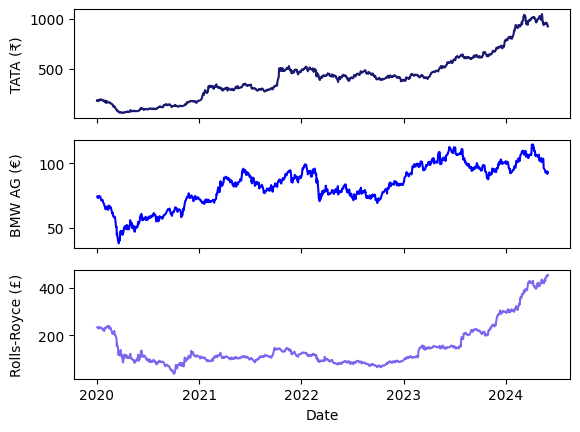

In [16]:
fig, axs = plt.subplots(3, 1, sharex=True)

rupee = u"\u20B9"
axs[0].plot(tata_close, color='midnightblue')
axs[0].set_ylabel(f'TATA ({rupee})')

euro = u"\u20ac"
axs[1].plot(bmw_close, color='blue')
axs[1].set_ylabel(f'BMW AG ({euro})')

axs[2].plot(rrl_close, color='mediumslateblue')
axs[2].set_ylabel('Rolls-Royce (£)')

axs[0].xaxis.set_major_locator(mdates.YearLocator())
axs[0].grid(True, 'minor')
axs[2].set_xlabel('Date')
fig.align_ylabels(axs)

###**Seasonal Decomposition**

In [17]:
bmw_decomp = seasonal_decompose(bmw_close, period=365)
tata_decomp = seasonal_decompose(tata_close, period=365)
rrl_decomp = seasonal_decompose(rrl_close, period=365)

###**Trends**

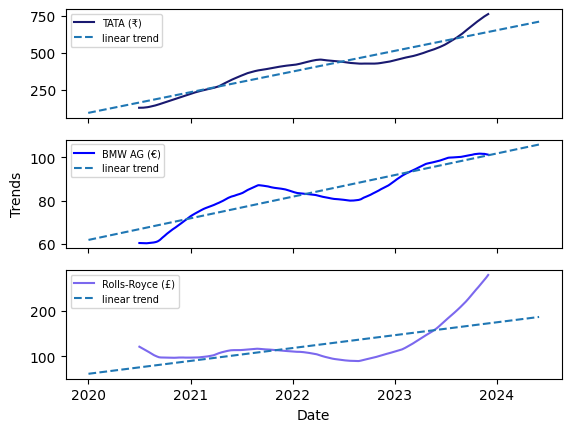

In [18]:
_tata = tata_decomp.trend
_bmw = bmw_decomp.trend
_rrl = rrl_decomp.trend

fig, axs = plt.subplots(3, 1, sharex=True)

x_axis = numpy.arange(_tata.size)
ign = numpy.isfinite(_tata)
gradient, intercept = numpy.polyfit(x_axis[ign], _tata[ign], deg=1)
best_fit = gradient * x_axis + intercept
axs[0].plot(tata_decomp.trend, color='midnightblue')
axs[0].plot(_tata.index, best_fit, linestyle='--')
axs[0].legend([f'TATA ({rupee})', 'linear trend'], fontsize=7)

x_axis = numpy.arange(_bmw.size)
ign = numpy.isfinite(_bmw)
gradient, intercept = numpy.polyfit(x_axis[ign], _bmw[ign], deg=1)
best_fit = gradient * x_axis + intercept
axs[1].plot(bmw_decomp.trend, color='blue')
axs[1].plot(_bmw.index, best_fit, linestyle='--')
axs[1].set_ylabel(f"Trends")
axs[1].legend([f"BMW AG ({euro})", 'linear trend'], fontsize=7)

x_axis = numpy.arange(_rrl.size)
ign = numpy.isfinite(_rrl)
gradient, intercept = numpy.polyfit(x_axis[ign], _rrl[ign], deg=1)
best_fit = gradient * x_axis + intercept
axs[2].plot(rrl_decomp.trend, color='mediumslateblue')
axs[2].plot(_rrl.index, best_fit, linestyle='--')
axs[2].legend(["Rolls-Royce (£)", 'linear trend'], fontsize=7)

axs[0].xaxis.set_major_locator(mdates.YearLocator())
axs[0].grid(True, 'minor')
axs[2].set_xlabel('Date')
fig.align_ylabels(axs)

###**Seasonality**

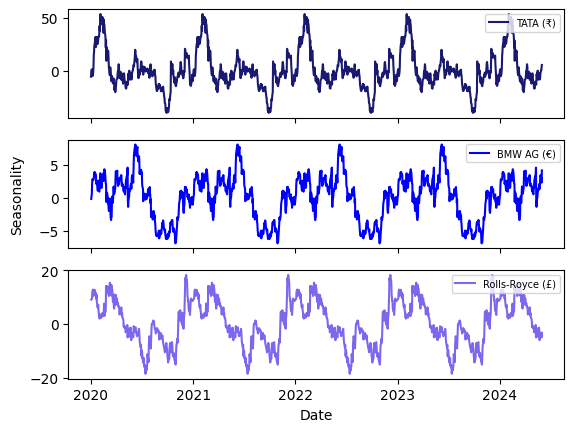

In [19]:
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(tata_decomp.seasonal, color='midnightblue')
axs[0].legend([f"TATA ({rupee})"], fontsize=7, loc='upper right')

axs[1].plot(bmw_decomp.seasonal, color='blue')
axs[1].set_ylabel('Seasonality')
axs[1].legend([f"BMW AG ({euro})"], fontsize=7, loc='upper right')

axs[2].plot(rrl_decomp.seasonal, color='mediumslateblue')
axs[2].legend(["Rolls-Royce (£)"], fontsize=7, loc='upper right')

axs[0].xaxis.set_major_locator(mdates.YearLocator())
axs[0].grid(True, 'minor')
axs[2].set_xlabel('Date')
fig.align_ylabels(axs)

###**Differencing**

In [20]:
tata_diff = tata_close.diff().dropna()
bmw_diff = bmw_close.diff().dropna()
rrl_diff = rrl_close.diff().dropna()

###**Residuals**

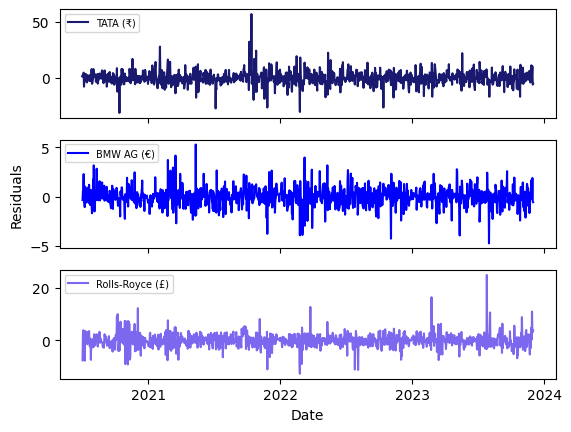

In [21]:
bmw_diff_decomp = seasonal_decompose(bmw_diff, period=365)
tata_diff_decomp = seasonal_decompose(tata_diff, period=365)
rrl_diff_decomp = seasonal_decompose(rrl_diff, period=365)

fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(tata_diff_decomp.resid, color='midnightblue')
axs[0].legend([f"TATA ({rupee})"], fontsize=7, loc='upper left')

axs[1].plot(bmw_diff_decomp.resid, color='blue')
axs[1].set_ylabel('Residuals')
axs[1].legend([f"BMW AG ({euro})"], fontsize=7, loc='upper left')

axs[2].plot(rrl_diff_decomp.resid, color='mediumslateblue')
axs[2].legend(["Rolls-Royce (£)"], fontsize=7, loc='upper left')

axs[0].xaxis.set_major_locator(mdates.YearLocator())
axs[0].grid(True, 'minor')
axs[2].set_xlabel('Date')
fig.align_ylabels(axs)

###**Outlier Detection**

In [22]:
_tata = tata_diff_decomp.resid.to_frame()
_bmw = bmw_diff_decomp.resid.to_frame()
_rrl = rrl_diff_decomp.resid.to_frame()

_tata['zscore'] = stats.zscore(_tata, nan_policy='omit')
_bmw['zscore'] = stats.zscore(_bmw, nan_policy='omit')
_rrl['zscore'] = stats.zscore(_rrl, nan_policy='omit')

_tata['outlier'] = _tata['zscore'].apply(
      lambda z: True if abs(z) > 3 else False)
_bmw['outlier'] = _bmw['zscore'].apply(
      lambda z: True if abs(z) > 3 else False)
_rrl['outlier'] = _rrl['zscore'].apply(
      lambda z: True if abs(z) > 3 else False)

tata_os = _tata['outlier'].sum()/len(_tata)
bmw_os = _bmw['outlier'].sum()/len(_bmw)
rrl_os = _rrl['outlier'].sum()/len(_rrl)

outliers = {
    'TATA Motors' : f'{tata_os:.2%}',
    'BMW AG' : f'{bmw_os:.2%}',
    'Rolls-Royce' : f'{rrl_os:.2%}'
}
outliers

{'TATA Motors': '0.99%', 'BMW AG': '1.18%', 'Rolls-Royce': '1.24%'}

###**Outlier Removal**

In [23]:
tata_cleaned = pandas.merge(tata_diff, _tata, on='Date', how='left')
tata_cleaned = tata_cleaned[tata_cleaned.outlier == False]
tata_cleaned = tata_cleaned['Close'].asfreq('D').interpolate()

bmw_cleaned = pandas.merge(bmw_diff, _bmw, on='Date')
bmw_cleaned = bmw_cleaned[bmw_cleaned.outlier == False]
bmw_cleaned = bmw_cleaned['Close'].asfreq('D').interpolate()

rrl_cleaned = pandas.merge(rrl_diff, _rrl, on='Date')
rrl_cleaned = rrl_cleaned[rrl_cleaned.outlier == False]
rrl_cleaned = rrl_cleaned['Close'].asfreq('D').interpolate()

###**Residuals Distribution**

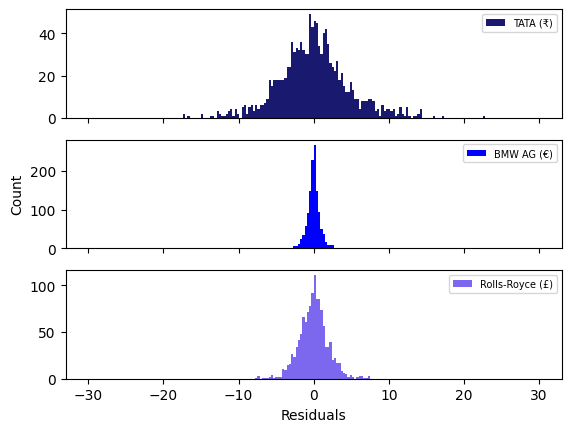

In [24]:
bmw_cleaned_decomp = seasonal_decompose(bmw_cleaned, period=365)
tata_cleaned_decomp = seasonal_decompose(tata_cleaned, period=365)
rrl_cleaned_decomp = seasonal_decompose(rrl_cleaned, period=365)

fig, axs = plt.subplots(3, 1, sharex=True)
axis_range = (-30, 30)
axs[0].hist(tata_cleaned_decomp.resid, color='midnightblue', bins=200, range=axis_range)
axs[0].legend([f'TATA ({rupee})'], fontsize=7)

axs[1].hist(bmw_cleaned_decomp.resid, color='blue', bins=200, range=axis_range)
axs[1].set_ylabel(f"Count")
axs[1].legend([f'BMW AG ({euro})'], fontsize=7)

axs[2].hist(rrl_cleaned_decomp.resid, color='mediumslateblue', bins=200, range=axis_range)
axs[2].legend(['Rolls-Royce (£)'], fontsize=7)

axs[0].grid(True, 'minor')
axs[2].set_xlabel('Residuals')
fig.align_ylabels(axs)

###**Yeo-Johnson Transformation**

In [25]:
tata_transformed = tata_cleaned.reset_index()
bmw_transformed = bmw_cleaned.reset_index()
rrl_transformed = rrl_cleaned.reset_index()

tata_transformed['Close'], lambda_tata= stats.yeojohnson(tata_transformed['Close'])
bmw_transformed['Close'], lambda_bmw = stats.yeojohnson(bmw_transformed['Close'])
rrl_transformed['Close'], lambda_rrl = stats.yeojohnson(rrl_transformed['Close'])

tata_transformed = tata_transformed[['Date', 'Close']]
bmw_transformed = bmw_transformed[['Date', 'Close']]
rrl_transformed = rrl_transformed[['Date', 'Close']]

tata_transformed = tata_transformed.set_index('Date')
bmw_transformed = bmw_transformed.set_index('Date')
rrl_transformed = rrl_transformed.set_index('Date')

YJ_TRANSFORM = {'TATA': stats.kurtosis(tata_transformed),
       'BMW': stats.kurtosis(bmw_transformed),
       'Rolls-Royce': stats.kurtosis(rrl_transformed)}
YJ_TRANSFORM

{'TATA': array([5.22490681]),
 'BMW': array([4.39105951]),
 'Rolls-Royce': array([10.37411811])}

###**Cube-root Transformation**

In [26]:
tata_transformed = tata_cleaned.reset_index()
bmw_transformed = bmw_cleaned.reset_index()
rrl_transformed = rrl_cleaned.reset_index()

tata_transformed['Close']= numpy.cbrt(tata_transformed['Close'])
bmw_transformed['Close'] = numpy.cbrt(bmw_transformed['Close'])
rrl_transformed['Close'] = numpy.cbrt(rrl_transformed['Close'])

tata_transformed = tata_transformed[['Date', 'Close']]
bmw_transformed = bmw_transformed[['Date', 'Close']]
rrl_transformed = rrl_transformed[['Date', 'Close']]

tata_transformed = tata_transformed.set_index('Date')
bmw_transformed = bmw_transformed.set_index('Date')
rrl_transformed = rrl_transformed.set_index('Date')

CBRT_TRANSFORM = {'TATA': stats.kurtosis(tata_transformed),
       'BMW': stats.kurtosis(bmw_transformed),
       'Rolls-Royce': stats.kurtosis(rrl_transformed)}
CBRT_TRANSFORM

{'TATA': array([-1.43702627]),
 'BMW': array([-1.40987858]),
 'Rolls-Royce': array([-1.38920744])}

###**Arcsinh Transformations**

In [27]:
tata_transformed = tata_cleaned.reset_index()
bmw_transformed = bmw_cleaned.reset_index()
rrl_transformed = rrl_cleaned.reset_index()

tata_transformed['Close']= numpy.arcsinh(tata_transformed['Close'])
bmw_transformed['Close'] = numpy.arcsinh(bmw_transformed['Close'])
rrl_transformed['Close'] = numpy.arcsinh(rrl_transformed['Close'])

tata_transformed = tata_transformed[['Date', 'Close']]
bmw_transformed = bmw_transformed[['Date', 'Close']]
rrl_transformed = rrl_transformed[['Date', 'Close']]

tata_transformed = tata_transformed.set_index('Date')
bmw_transformed = bmw_transformed.set_index('Date')
rrl_transformed = rrl_transformed.set_index('Date')

ARCSINH_TRANSFORM = {'TATA': stats.kurtosis(tata_transformed),
       'BMW': stats.kurtosis(bmw_transformed),
       'Rolls-Royce': stats.kurtosis(rrl_transformed)}
ARCSINH_TRANSFORM

{'TATA': array([-1.11741934]),
 'BMW': array([0.37322471]),
 'Rolls-Royce': array([-0.61335639])}

###**Transformation Comparison**

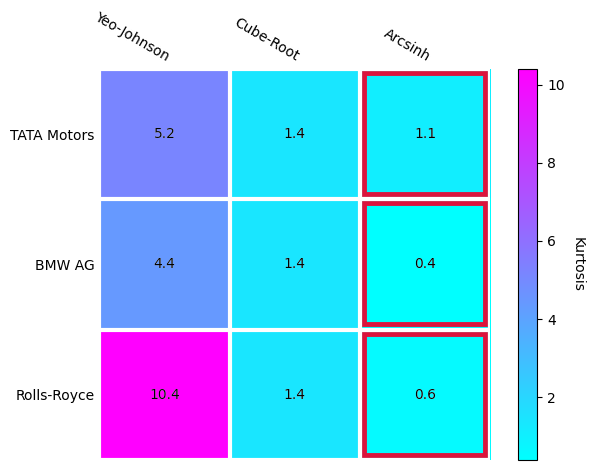

In [28]:
fig, ax = plt.subplots();
stocks = ['TATA Motors', 'BMW AG', 'Rolls-Royce']
transformations = ['Yeo-Johnson', 'Cube-Root', 'Arcsinh']
yeo_johnson = [YJ_TRANSFORM['TATA'][0], YJ_TRANSFORM['BMW'][0], YJ_TRANSFORM['Rolls-Royce'][0]]
cbrt = [CBRT_TRANSFORM['TATA'][0], CBRT_TRANSFORM['BMW'][0], CBRT_TRANSFORM['Rolls-Royce'][0]]
arcsinh = [ARCSINH_TRANSFORM['TATA'][0], ARCSINH_TRANSFORM['BMW'][0], ARCSINH_TRANSFORM['Rolls-Royce'][0]]
yeo_johnson = [round(abs(i), 1) for i in yeo_johnson]
cbrt = [round(abs(i), 1) for i in cbrt]
arcsinh = [round(abs(i), 1) for i in arcsinh]
comparison = numpy.array(list(zip(yeo_johnson, cbrt, arcsinh)))
heatmap = ax.imshow(comparison, cmap='cool')
ax.set_xticks(range(len(transformations)), labels=transformations,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(stocks)), labels=stocks)
for i in range(len(stocks)):
    for j in range(len(transformations)):
        text = ax.text(j, i, comparison[i, j],
                       ha="center", va="center", color="w")
colour_bar = ax.figure.colorbar(heatmap, ax=ax, cmap='cool')
colour_bar.ax.set_ylabel('Kurtosis', rotation=-90, va="bottom")
ax.set_xticks(range(comparison.shape[1]), labels=transformations,
                  rotation=-30, ha="right", rotation_mode="anchor")
ax.set_yticks(range(comparison.shape[0]), labels=stocks)
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
ax.spines[:].set_visible(False)
ax.set_xticks(numpy.arange(comparison.shape[1]+1)-.5, minor=True)
ax.set_yticks(numpy.arange(comparison.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
threshold = heatmap.norm(comparison.max())/2
formatter = StrMethodFormatter('{x:.1f}')
colours = ('black', 'white')
kwargs = dict(
    horizontalalignment="center",
    verticalalignment="center",
    color=colours[int(heatmap.norm(comparison[i, j]) > threshold)],
    #fontweight='bold'
)
for i in range(comparison.shape[0]):
    for j in range(comparison.shape[1]):
       heatmap.axes.text(j, i, formatter(comparison[i, j], None), kwargs)
x, y, width, height = 0, 1.5, 3, 1
for y in range(3):
    ax.add_patch(Rectangle((1.53,y-0.47), 0.93, 0.93, fill=False, edgecolor='crimson', lw=3.5, clip_on=False))
ax.tick_params(length=0)
fig.tight_layout()

###**Residual Autocorrelation**

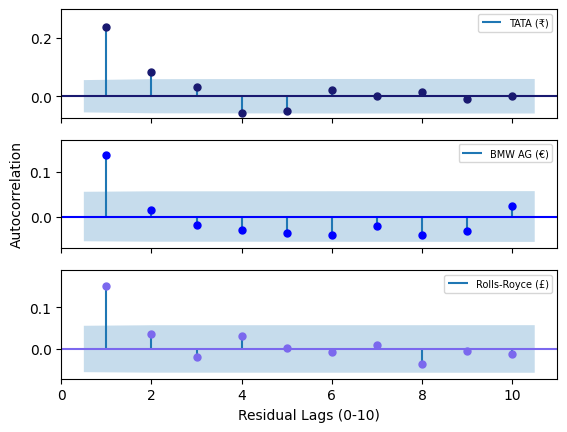

In [29]:
bmw_transformed_decomp = seasonal_decompose(bmw_transformed, period=365)
tata_transformed_decomp = seasonal_decompose(tata_transformed, period=365)
rrl_transformed_decomp = seasonal_decompose(rrl_transformed, period=365)

tata_resid = tata_transformed_decomp.resid.dropna()
bmw_resid = bmw_transformed_decomp.resid.dropna()
rrl_resid = rrl_transformed_decomp.resid.dropna()

fig, axs = plt.subplots(3, 1, sharex=True);

plot_acf(tata_resid, title=None, color='midnightblue', lags=10, zero=False, auto_ylims=True, ax=axs[0])
axs[0].legend([f'TATA ({rupee})'], fontsize=7)

plot_acf(bmw_resid, title=None, color='blue', lags=10, zero=False, auto_ylims=True, ax=axs[1])
axs[1].set_ylabel("Autocorrelation")
axs[1].legend([f'BMW AG ({euro})'], fontsize=7)

plot_acf(rrl_resid, title=None, color='mediumslateblue', lags=10, zero=False, auto_ylims=True, ax=axs[2])
axs[2].legend(['Rolls-Royce (£)'], fontsize=7)

axs[2].set_xlabel("Residual Lags (0-10)")
axs[0].grid(True, 'minor')
fig.align_ylabels(axs)

###**Autocorrelation**

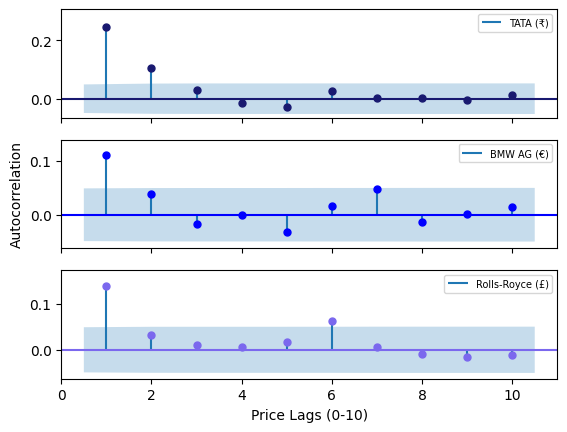

In [30]:
fig, axs = plt.subplots(3, 1, sharex=True);

plot_acf(tata_transformed, title=None, color='midnightblue', lags=10, zero=False, auto_ylims=True, ax=axs[0])
axs[0].legend([f'TATA ({rupee})'], fontsize=7)

plot_acf(bmw_transformed, title=None, color='blue', lags=10, zero=False, auto_ylims=True, ax=axs[1])
axs[1].set_ylabel(f"Autocorrelation")
axs[1].legend([f'BMW AG ({euro})'], fontsize=7)

plot_acf(rrl_transformed, title=None, color='mediumslateblue', lags=10, zero=False, auto_ylims=True, ax=axs[2])
axs[2].legend(['Rolls-Royce (£)'], fontsize=7)

axs[2].set_xlabel("Price Lags (0-10)")
axs[0].grid(True, 'minor')
fig.align_ylabels(axs)

###**Partial Autocorrelation**

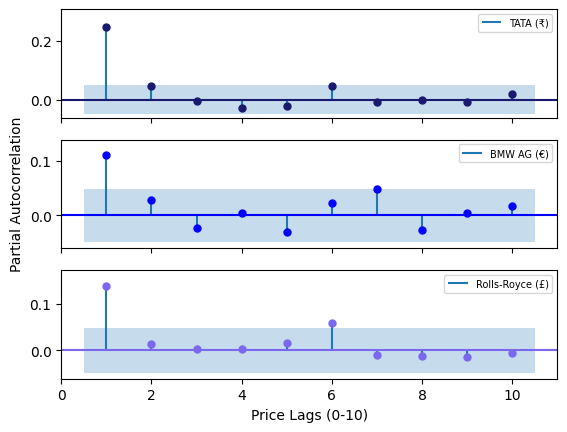

In [31]:
fig, axs = plt.subplots(3, 1, sharex=True);

plot_pacf(tata_transformed, title=None, color='midnightblue', lags=10, zero=False, auto_ylims=True, ax=axs[0])
axs[0].legend([f'TATA ({rupee})'], fontsize=7)

plot_pacf(bmw_transformed, title=None, color='blue', lags=10, zero=False, auto_ylims=True, ax=axs[1])
axs[1].set_ylabel(f"Partial Autocorrelation")
axs[1].legend([f'BMW AG ({euro})'], fontsize=7)

plot_pacf(rrl_transformed, title=None, color='mediumslateblue', lags=10, zero=False, auto_ylims=True, ax=axs[2])
axs[2].legend(['Rolls-Royce (£)'], fontsize=7)

axs[2].set_xlabel("Price Lags (0-10)")
axs[0].grid(True, 'minor')
fig.align_ylabels(axs)

#**Analytics**

###**Train Sets**

In [32]:
tata_train = tata_transformed.copy()
bmw_train = bmw_transformed.copy()
rrl_train = rrl_transformed.copy()

###**AIC Performance**

In [33]:
tata_orders = list(list((i[0], 0, i[1])) for i in product([0, 1, 2, 3], [0, 1, 2, 3]))
bmw_orders = list(list((i[0], 0, i[1])) for i in product([0, 1, 2, 3], [0, 1, 2, 3]))
rrl_orders = list(list((i[0], 0, i[1])) for i in product([0, 1, 2, 3], [0, 1, 2, 3]))

tata_aic = []
for order in tata_orders:
  model = ARIMA(tata_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit()
  tata_aic.append(model.aic)

bmw_aic = []
for order in bmw_orders:
  model = ARIMA(bmw_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit()
  bmw_aic.append(model.aic)

rrl_aic = []
for order in rrl_orders:
  model = ARIMA(rrl_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit()
  rrl_aic.append(model.aic)

tata_str_orders = [str(tuple(j)) for j in tata_orders]
bmw_str_orders = [str(tuple(j)) for j in bmw_orders]
rrl_str_orders = [str(tuple(j)) for j in rrl_orders]

tata_pairs = dict(zip(tata_str_orders, tata_aic))
bmw_pairs = dict(zip(bmw_str_orders, bmw_aic))
rrl_pairs = dict(zip(rrl_str_orders, rrl_aic))

orders = list(set(tata_str_orders + bmw_str_orders + rrl_str_orders))
orders.sort()

tata_aic_res = [tata_pairs.get(i) for i in orders]
bmw_aic_res = [bmw_pairs.get(i) for i in orders]
rrl_aic_res = [rrl_pairs.get(i) for i in orders]

AIC_table = pandas.DataFrame.from_dict(
    {'Orders':orders,
     'TATA':tata_aic_res,
     'BMW AG':bmw_aic_res,
     'Rolls-Royce':rrl_aic_res})
AIC_table.style.format({'TATA':'{:.1f}', 'BMW AG':'{:.1f}', 'Rolls-Royce':'{:.1f}'})

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

,Orders,TATA,BMW AG,Rolls-Royce
0,"(0, 0, 0)",6721.8,3706.7,5686.5
1,"(0, 0, 1)",6632.5,3688.7,5656.3
2,"(0, 0, 2)",6616.2,3686.4,5654.3
3,"(0, 0, 3)",6611.9,3686.6,5653.7
4,"(1, 0, 0)",6624.0,3688.6,5657.5
5,"(1, 0, 1)",6617.5,3688.5,5656.7
6,"(1, 0, 2)",6615.7,3687.8,5654.0
7,"(1, 0, 3)",6613.9,3688.0,5653.3
8,"(2, 0, 0)",6617.4,3688.1,5656.7
9,"(2, 0, 1)",6619.4,3689.3,5658.7


###**Model Training**

In [34]:
# Transformed data already differenced so remove differencing-order
tata_train = tata_transformed.copy()
bmw_train = bmw_transformed.copy()
rrl_train = rrl_transformed.copy()

tata_model = ARIMA(tata_train, order=(0,0,3), enforce_stationarity=False, enforce_invertibility=False)
tata_model = tata_model.fit()

bmw_model = ARIMA(bmw_train, order=(0, 0, 2), enforce_stationarity=False, enforce_invertibility=False)
bmw_model = bmw_model.fit()

rrl_model = ARIMA(rrl_train, order=(3,0,3), enforce_stationarity=False, enforce_invertibility=False)
rrl_model = rrl_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

###**Performance Diagnostics**

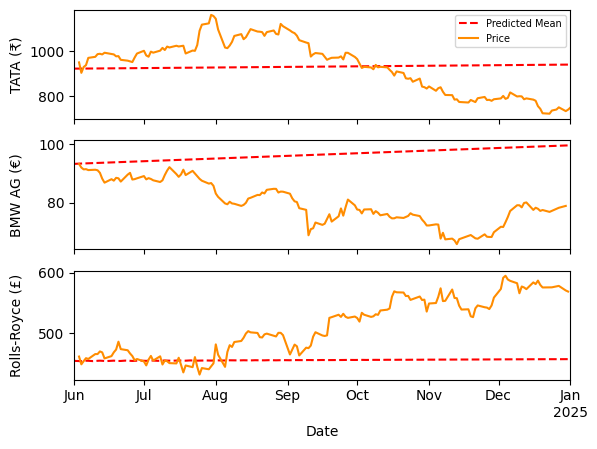

In [35]:
END = datetime.datetime(2025, 7, 31)
tata_pred = tata_model.predict(start=SPLIT1, end=SPLIT2)
bmw_pred = bmw_model.predict(start=SPLIT1, end=SPLIT2)
rrl_pred = rrl_model.predict(start=SPLIT1, end=SPLIT2)

fig, axs = plt.subplots(3, 1, sharex=True)
tata_sinh = numpy.sinh(tata_pred.copy())
tata_fin = tata_close.copy().reset_index()
tata_fin = tata_fin[tata_fin.Date == tata_fin.Date.max()]
tata_undiff = numpy.r_[tata_fin.Close, tata_pred].cumsum()
_tata_pred = tata_pred.copy().reset_index()
_tata_pred['predicted_mean'] = tata_undiff[1:]
_tata_pred.rename(columns={'index':'Date'}, inplace=True)
_tata_pred.set_index('Date', inplace=True)
_tata_pred.plot(ax=axs[0], color='red', linestyle='dashed')
tata_val.plot(ax=axs[0], color='darkorange')
axs[0].legend(['Predicted Mean', 'Price'], fontsize=7)
axs[0].set_ylabel(f'TATA ({rupee})')

bmw_sinh = numpy.sinh(bmw_pred.copy())
bmw_fin = bmw_close.copy().reset_index()
bmw_fin = bmw_fin[bmw_fin.Date == bmw_fin.Date.max()]
bmw_undiff = numpy.r_[bmw_fin.Close, bmw_pred].cumsum()
_bmw_pred = bmw_pred.copy().reset_index()
_bmw_pred['predicted_mean'] = bmw_undiff[1:]
_bmw_pred.rename(columns={'index':'Date'}, inplace=True)
_bmw_pred.set_index('Date', inplace=True)
_bmw_pred.plot(ax=axs[1], color='red', linestyle='dashed')
bmw_val.plot(ax=axs[1], color='darkorange')
axs[1].get_legend().set_visible(False)
axs[1].set_ylabel(f'BMW AG ({euro})')

rrl_sinh = numpy.sinh(rrl_pred.copy())
rrl_fin = rrl_close.copy().reset_index()
rrl_fin = rrl_fin[rrl_fin.Date == rrl_fin.Date.max()]
rrl_undiff = numpy.r_[rrl_fin.Close, rrl_pred].cumsum()
_rrl_pred = rrl_pred.copy().reset_index()
_rrl_pred['predicted_mean'] = rrl_undiff[1:]
_rrl_pred.rename(columns={'index':'Date'}, inplace=True)
_rrl_pred.set_index('Date', inplace=True)
_rrl_pred.plot(ax=axs[2], color='red', linestyle='dashed')
rrl_val.plot(ax=axs[2], color='darkorange')
axs[2].get_legend().set_visible(False)
axs[2].set_ylabel('Rolls-Royce (£)')

axs[0].minorticks_off()
axs[0].xaxis.set_major_locator(mdates.MonthLocator())
fig.align_ylabels(axs)

###**Regime-Change Analysis**

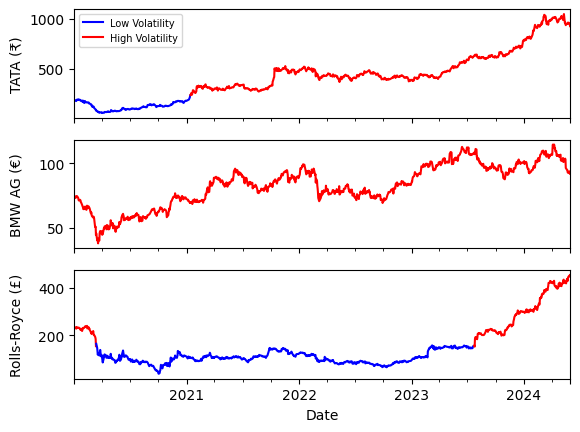

In [36]:
tata_mr = MarkovRegression(tata_close.dropna(), k_regimes=2, trend='n', switching_variance=True)
tata_mr = tata_mr.fit()
tata_low_vol = numpy.array(tata_mr.smoothed_marginal_probabilities[0])
tata_high_vol = numpy.array(tata_mr.smoothed_marginal_probabilities[1])

bmw_mr = MarkovRegression(bmw_close.dropna(), k_regimes=2, trend='n', switching_variance=True)
bmw_mr = bmw_mr.fit()
bmw_low_vol = numpy.array(bmw_mr.smoothed_marginal_probabilities[0])
bmw_high_vol = numpy.array(bmw_mr.smoothed_marginal_probabilities[1])

rrl_mr = MarkovRegression(rrl_close.dropna(), k_regimes=2, trend='n', switching_variance=True)
rrl_mr = rrl_mr.fit()
rrl_low_vol = numpy.array(rrl_mr.smoothed_marginal_probabilities[0])
rrl_high_vol = numpy.array(rrl_mr.smoothed_marginal_probabilities[1])

tata_vol = (tata_low_vol < tata_high_vol).astype('int')
bmw_vol = (bmw_low_vol < bmw_high_vol).astype('int')
rrl_vol = (rrl_low_vol < rrl_high_vol).astype('int')

cmap = {0:'blue', 1:'red'}
tata_markov = tata_close.dropna().reset_index().copy()
bmw_markov = bmw_close.dropna().reset_index().copy()
rrl_markov = rrl_close.dropna().reset_index().copy()

tata_markov['regime'] = [cmap[i] for i in tata_vol]
bmw_markov['regime'] = [cmap[i] for i in bmw_vol]
rrl_markov['regime'] = [cmap[i] for i in rrl_vol]

tata_markov.set_index('Date', inplace=True)
bmw_markov.set_index('Date', inplace=True)
rrl_markov.set_index('Date', inplace=True)

tata_markov['change'] = tata_markov['regime'].ne(tata_markov['regime'].shift()).cumsum()
bmw_markov['change'] = bmw_markov['regime'].ne(bmw_markov['regime'].shift()).cumsum()
rrl_markov['change'] = rrl_markov['regime'].ne(rrl_markov['regime'].shift()).cumsum()

fig, axs = plt.subplots(3,1, sharex=True)

for chg in tata_markov['change'].unique():
  table = tata_markov[tata_markov.change == chg].copy()
  colour = table.regime.to_list()[0]
  table[['Close']].plot(color=colour, ax=axs[0])
axs[0].legend(['Low Volatility', 'High Volatility'], fontsize=7)
axs[0].set_ylabel(f'TATA ({rupee})')

for chg in bmw_markov['change'].unique():
  table = bmw_markov[bmw_markov.change == chg].copy()
  colour = table.regime.to_list()[0]
  table[['Close']].plot(color=colour, ax=axs[1])
axs[1].get_legend().set_visible(False)
axs[1].set_ylabel(f'BMW AG ({euro})')

for chg in rrl_markov['change'].unique():
  table = rrl_markov[rrl_markov.change == chg].copy()
  colour = table.regime.to_list()[0]
  table[['Close']].plot(color=colour, ax=axs[2])
axs[2].get_legend().set_visible(False)
axs[2].set_ylabel('Rolls-Royce (£)')
fig.align_ylabels(axs);

###**Resampling**

In [37]:
_tata_regime = tata_markov[tata_markov.change == 2].reset_index().iloc[0,0]
_tata_regime = _tata_regime.date()
_tata_regime = datetime.datetime(_tata_regime.year, _tata_regime.month, _tata_regime.day)
_tata_train = tata_train.reset_index()
_tata_train = _tata_train[_tata_train.Date >= _tata_regime]
_tata_train.set_index('Date', inplace=True)

_bmw_regime = bmw_markov[bmw_markov.change == 1].reset_index().iloc[0,0]
_bmw_regime = _bmw_regime.date()
_bmw_regime = datetime.datetime(_bmw_regime.year, _bmw_regime.month, _bmw_regime.day)
_bmw_train = bmw_train.reset_index()
_bmw_train = _bmw_train[_bmw_train.Date >= _bmw_regime]
_bmw_train.set_index('Date', inplace=True)

_rrl_regime = rrl_markov[rrl_markov.change == 3].reset_index().iloc[0,0]
_rrl_regime = _rrl_regime.date()
_rrl_regime = datetime.datetime(_rrl_regime.year, _rrl_regime.month, _rrl_regime.day)
_rrl_train = rrl_train.reset_index()
_rrl_train = _rrl_train[_rrl_train.Date >= _rrl_regime]
_rrl_train.set_index('Date', inplace=True)

tata_aic = []
for order in tata_orders:
  model = ARIMA(_tata_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit()
  tata_aic.append(model.aic)

bmw_aic = []
for order in bmw_orders:
  model = ARIMA(_bmw_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit()
  bmw_aic.append(model.aic)

rrl_aic = []
for order in rrl_orders:
  model = ARIMA(_rrl_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit()
  rrl_aic.append(model.aic)

tata_str_orders = [str(tuple(j)) for j in tata_orders]
bmw_str_orders = [str(tuple(j)) for j in bmw_orders]
rrl_str_orders = [str(tuple(j)) for j in rrl_orders]

tata_pairs = dict(zip(tata_str_orders, tata_aic))
bmw_pairs = dict(zip(bmw_str_orders, bmw_aic))
rrl_pairs = dict(zip(rrl_str_orders, rrl_aic))

orders = list(set(tata_str_orders + bmw_str_orders + rrl_str_orders))
orders.sort()

tata_aic_res = [tata_pairs.get(i) for i in orders]
bmw_aic_res = [bmw_pairs.get(i) for i in orders]
rrl_aic_res = [rrl_pairs.get(i) for i in orders]

AIC_table = pandas.DataFrame.from_dict(
    {'Orders':orders,
     'TATA':tata_aic_res,
     'BMW AG':bmw_aic_res,
     'Rolls-Royce':rrl_aic_res})
AIC_table.style.format({'TATA':'{:.1f}', 'BMW AG':'{:.1f}', 'Rolls-Royce':'{:.1f}'})

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

,Orders,TATA,BMW AG,Rolls-Royce
0,"(0, 0, 0)",5296.3,3706.7,1198.9
1,"(0, 0, 1)",5230.1,3688.7,1194.9
2,"(0, 0, 2)",5216.6,3686.4,1193.7
3,"(0, 0, 3)",5212.9,3686.6,1190.5
4,"(1, 0, 0)",5225.4,3688.6,1199.7
5,"(1, 0, 1)",5222.5,3688.5,1196.8
6,"(1, 0, 2)",5218.3,3687.8,1195.4
7,"(1, 0, 3)",5214.9,3688.0,1192.3
8,"(2, 0, 0)",5222.5,3688.1,1196.5
9,"(2, 0, 1)",5223.7,3689.3,1198.8


###**Optimised Model Training**

In [38]:
tata_model = ARIMA(_tata_train, order=(2,0,3), enforce_stationarity=False, enforce_invertibility=False)
tata_model = tata_model.fit()

bmw_model = ARIMA(_bmw_train, order=(0, 0, 2), enforce_stationarity=False, enforce_invertibility=False)
bmw_model = bmw_model.fit()

rrl_model = ARIMA(_rrl_train, order=(3,0,3), enforce_stationarity=False, enforce_invertibility=False)
rrl_model = rrl_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

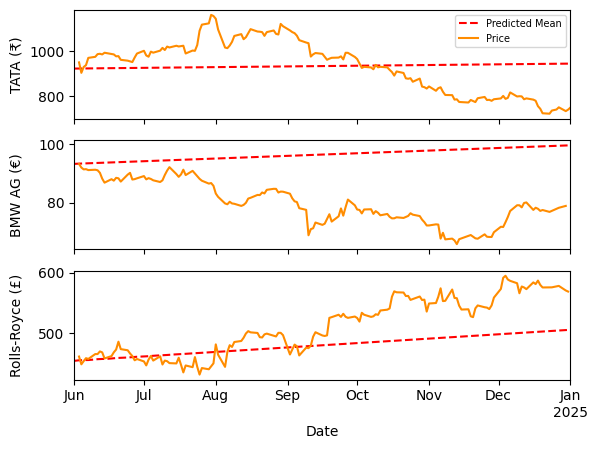

In [39]:
tata_pred = tata_model.predict(start=SPLIT1, end=SPLIT2)
bmw_pred = bmw_model.predict(start=SPLIT1, end=SPLIT2)
rrl_pred = rrl_model.predict(start=SPLIT1, end=SPLIT2)

fig, axs = plt.subplots(3, 1, sharex=True)
tata_sinh = numpy.sinh(tata_pred.copy())
tata_fin = tata_close.copy().reset_index()
tata_fin = tata_fin[tata_fin.Date == tata_fin.Date.max()]
tata_undiff = numpy.r_[tata_fin.Close, tata_pred].cumsum()
_tata_pred = tata_pred.copy().reset_index()
_tata_pred['predicted_mean'] = tata_undiff[1:]
_tata_pred.rename(columns={'index':'Date'}, inplace=True)
_tata_pred.set_index('Date', inplace=True)
_tata_pred.plot(ax=axs[0], color='red', linestyle='dashed')
tata_val.plot(ax=axs[0], color='darkorange')
axs[0].legend(['Predicted Mean', 'Price'], fontsize=7)
axs[0].set_ylabel(f'TATA ({rupee})')

bmw_sinh = numpy.sinh(bmw_pred.copy())
bmw_fin = bmw_close.copy().reset_index()
bmw_fin = bmw_fin[bmw_fin.Date == bmw_fin.Date.max()]
bmw_undiff = numpy.r_[bmw_fin.Close, bmw_pred].cumsum()
_bmw_pred = bmw_pred.copy().reset_index()
_bmw_pred['predicted_mean'] = bmw_undiff[1:]
_bmw_pred.rename(columns={'index':'Date'}, inplace=True)
_bmw_pred.set_index('Date', inplace=True)
_bmw_pred.plot(ax=axs[1], color='red', linestyle='dashed')
bmw_val.plot(ax=axs[1], color='darkorange')
axs[1].get_legend().set_visible(False)
axs[1].set_ylabel(f'BMW AG ({euro})')

rrl_sinh = numpy.sinh(rrl_pred.copy())
rrl_fin = rrl_close.copy().reset_index()
rrl_fin = rrl_fin[rrl_fin.Date == rrl_fin.Date.max()]
rrl_undiff = numpy.r_[rrl_fin.Close, rrl_pred].cumsum()
_rrl_pred = rrl_pred.copy().reset_index()
_rrl_pred['predicted_mean'] = rrl_undiff[1:]
_rrl_pred.rename(columns={'index':'Date'}, inplace=True)
_rrl_pred.set_index('Date', inplace=True)
_rrl_pred.plot(ax=axs[2], color='red', linestyle='dashed')
rrl_val.plot(ax=axs[2], color='darkorange')
axs[2].get_legend().set_visible(False)
axs[2].set_ylabel(f'Rolls-Royce (£)')

axs[0].minorticks_off()
#axs[0].xaxis.set_major_locator(mdates.YearLocator())
fig.align_ylabels(axs);

In [40]:
tata_val_transformed = numpy.arcsinh(tata_val.diff()).dropna()
bmw_val_transformed = numpy.arcsinh(bmw_val.diff()).dropna()
rrl_val_transformed = numpy.arcsinh(rrl_val.diff()).dropna()

###**Re-training on Validation Set**

In [41]:
tata_concat = pandas.concat([_tata_train.reset_index(), tata_val_transformed.reset_index()])
bmw_concat = pandas.concat([_bmw_train.reset_index(), bmw_val_transformed.reset_index()])
rrl_concat = pandas.concat([_rrl_train.reset_index(), rrl_val_transformed.reset_index()])

tata_concat.set_index('Date', inplace=True)
bmw_concat.set_index('Date', inplace=True)
rrl_concat.set_index('Date', inplace=True)

tata_model = ARIMA(tata_concat, order=(2,0,3), enforce_stationarity=False, enforce_invertibility=False, missing='drop')
tata_model = tata_model.fit()

bmw_model = ARIMA(bmw_concat, order=(0, 0, 2), enforce_stationarity=False, enforce_invertibility=False, missing='drop')
bmw_model = bmw_model.fit()

rrl_model = ARIMA(rrl_concat, order=(3,0,3), enforce_stationarity=False, enforce_invertibility=False, missing='drop')
rrl_model = rrl_model.fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [42]:
tata_start = tata_concat.reset_index()['Date'].min()
tata_end = tata_concat.reset_index()['Date'].max()

bmw_start = bmw_concat.reset_index()['Date'].min()
bmw_end = bmw_concat.reset_index()['Date'].max()

rrl_start = rrl_concat.reset_index()['Date'].min()
rrl_end = rrl_concat.reset_index()['Date'].max()
print(tata_start, tata_end, bmw_start, bmw_end, rrl_start, rrl_end)

2021-01-13 00:00:00 2025-01-01 00:00:00 2020-01-03 00:00:00 2024-12-30 00:00:00 2023-07-24 00:00:00 2024-12-31 00:00:00


###**Performance Diagnostics**

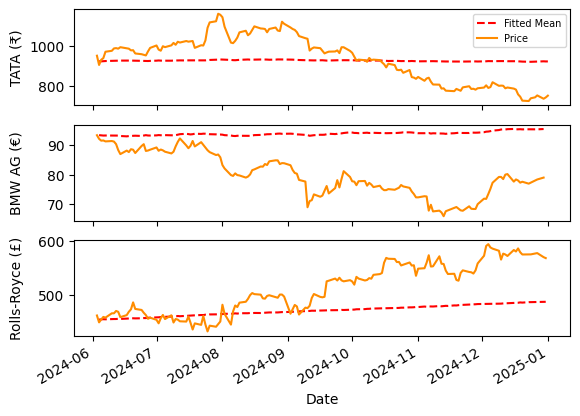

In [43]:
tata_pred = tata_model.fittedvalues.reset_index()
bmw_pred = bmw_model.fittedvalues.reset_index()
rrl_pred = rrl_model.fittedvalues.reset_index()

tata_pred.rename(columns={0:'fitted_mean'}, inplace=True)
bmw_pred.rename(columns={0:'fitted_mean'}, inplace=True)
rrl_pred.rename(columns={0:'fitted_mean'}, inplace=True)

tata_pred = tata_pred[tata_pred.Date > SPLIT1]
bmw_pred = bmw_pred[bmw_pred.Date > SPLIT1]
rrl_pred = rrl_pred[rrl_pred.Date > SPLIT1]

tata_pred.set_index('Date', inplace=True)
bmw_pred.set_index('Date', inplace=True)
rrl_pred.set_index('Date', inplace=True)

fig, axs = plt.subplots(3, 1, sharex=True)
tata_sinh = numpy.sinh(tata_pred.copy())
tata_fin = tata_close.copy().reset_index()
tata_fin = tata_fin[tata_fin.Date == tata_fin.Date.max()]
tata_undiff = numpy.r_[tata_fin.Close, tata_pred.fitted_mean].cumsum()
_tata_pred = tata_pred.copy().reset_index()
_tata_pred['fitted_mean'] = tata_undiff[1:]
_tata_pred.rename(columns={'index':'Date'}, inplace=True)
_tata_pred.set_index('Date', inplace=True)
_tata_pred.plot(ax=axs[0], color='red', linestyle='dashed')
tata_val.plot(ax=axs[0], color='darkorange')
axs[0].legend(['Fitted Mean', 'Price'], fontsize=7)
axs[0].set_ylabel(f'TATA ({rupee})')

bmw_sinh = numpy.sinh(bmw_pred.copy())
bmw_fin = bmw_close.copy().reset_index()
bmw_fin = bmw_fin[bmw_fin.Date == bmw_fin.Date.max()]
bmw_undiff = numpy.r_[bmw_fin.Close, bmw_pred.fitted_mean].cumsum()
_bmw_pred = bmw_pred.copy().reset_index()
_bmw_pred['fitted_mean'] = bmw_undiff[1:]
_bmw_pred.rename(columns={'index':'Date'}, inplace=True)
_bmw_pred.set_index('Date', inplace=True)
_bmw_pred.plot(ax=axs[1], color='red', linestyle='dashed')
bmw_val.plot(ax=axs[1], color='darkorange')
axs[1].get_legend().set_visible(False)
axs[1].set_ylabel(f'BMW AG ({euro})')

rrl_sinh = numpy.sinh(rrl_pred.copy())
rrl_fin = rrl_close.copy().reset_index()
rrl_fin = rrl_fin[rrl_fin.Date == rrl_fin.Date.max()]
rrl_undiff = numpy.r_[rrl_fin.Close, rrl_pred.fitted_mean].cumsum()
_rrl_pred = rrl_pred.copy().reset_index()
_rrl_pred['fitted_mean'] = rrl_undiff[1:]
_rrl_pred.rename(columns={'index':'Date'}, inplace=True)
_rrl_pred.set_index('Date', inplace=True)
_rrl_pred.plot(ax=axs[2], color='red', linestyle='dashed')
rrl_val.plot(ax=axs[2], color='darkorange')
axs[2].get_legend().set_visible(False)
axs[2].set_ylabel(f'Rolls-Royce (£)')

axs[0].minorticks_off()
axs[0].xaxis.set_major_locator(mdates.MonthLocator())
fig.align_ylabels(axs);

###**Validation-Set Error-Metrics**

In [45]:
tata_comp = pandas.merge(_tata_pred, tata_val, on='Date')
tata_mse = mse(tata_comp.fitted_mean, tata_comp.Close)
tata_mae = meanabs(tata_comp.fitted_mean, tata_comp.Close)
tata_rmse = rmse(tata_comp.fitted_mean, tata_comp.Close)
tata_mape = mape(tata_comp.fitted_mean, tata_comp.Close)

bmw_comp = pandas.merge(_bmw_pred, bmw_val, on='Date')
bmw_mse = mse(bmw_comp.fitted_mean, bmw_comp.Close)
bmw_mae = meanabs(bmw_comp.fitted_mean, bmw_comp.Close)
bmw_rmse = rmse(bmw_comp.fitted_mean, bmw_comp.Close)
bmw_mape = mape(bmw_comp.fitted_mean, bmw_comp.Close)

rrl_comp = pandas.merge(_rrl_pred, rrl_val, on='Date')
rrl_mse = mse(rrl_comp.fitted_mean, rrl_comp.Close)
rrl_mae = meanabs(rrl_comp.fitted_mean, rrl_comp.Close)
rrl_rmse = rmse(rrl_comp.fitted_mean, rrl_comp.Close)
rrl_mape = mape(rrl_comp.fitted_mean, rrl_comp.Close)

init_errs = pandas.DataFrame(
    {'Metrics':['MSE', 'MAE', 'RMSE', 'MAPE'],
     'TATA':[tata_mse, tata_mae, tata_rmse, tata_mape],
     'BMW':[bmw_mse, bmw_mae, bmw_rmse, bmw_mape],
     'Rolls-Royce':[rrl_mse, rrl_mae, rrl_rmse, rrl_mape]})
init_errs

,Metrics,TATA,BMW,Rolls-Royce
0,MSE,12794.770828,252.506743,3087.410513
1,MAE,98.141425,14.007861,44.529895
2,RMSE,113.113973,15.890461,55.564472
3,MAPE,0.106005,0.149114,0.093527


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

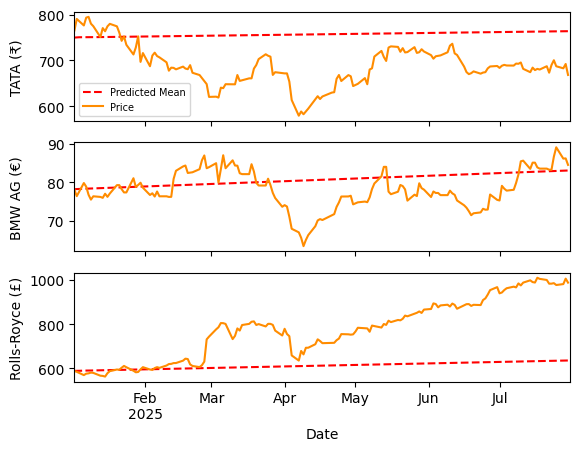

In [46]:
tata_pred = tata_model.forecast(steps=211).reset_index()
bmw_pred = bmw_model.forecast(steps=211).reset_index()
rrl_pred = rrl_model.forecast(steps=211).reset_index()

tata_pred['Date'] = pandas.date_range(start=SPLIT2+datetime.timedelta(days=1), end=END)
bmw_pred['Date'] = pandas.date_range(start=SPLIT2+datetime.timedelta(days=1), end=END)
rrl_pred['Date'] = pandas.date_range(start=SPLIT2+datetime.timedelta(days=1), end=END)

tata_pred.set_index('Date', inplace=True)
bmw_pred.set_index('Date', inplace=True)
rrl_pred.set_index('Date', inplace=True)

tata_pred = tata_pred[['predicted_mean']]
bmw_pred = bmw_pred[['predicted_mean']]
rrl_pred = rrl_pred[['predicted_mean']]

fig, axs = plt.subplots(3, 1, sharex=True)
tata_sinh = numpy.sinh(tata_pred.copy())
tata_fin = tata_test.copy().reset_index()
tata_fin = tata_fin[tata_fin.Date == tata_fin.Date.min()]
tata_undiff = numpy.r_[tata_fin.Close, tata_pred.predicted_mean].cumsum()
_tata_pred = tata_pred.copy().reset_index()
_tata_pred['predicted_mean'] = tata_undiff[1:]
_tata_pred.rename(columns={'index':'Date'}, inplace=True)
_tata_pred.set_index('Date', inplace=True)
_tata_pred.plot(ax=axs[0], color='red', linestyle='dashed')
tata_test.plot(ax=axs[0], color='darkorange')
axs[0].legend(['Predicted Mean', 'Price'], fontsize=7)
axs[0].set_ylabel(f'TATA ({rupee})')

bmw_sinh = numpy.sinh(bmw_pred.copy())
bmw_fin = bmw_test.copy().reset_index()
bmw_fin = bmw_fin[bmw_fin.Date == bmw_fin.Date.min()]
bmw_undiff = numpy.r_[bmw_fin.Close, bmw_pred.predicted_mean].cumsum()
_bmw_pred = bmw_pred.copy().reset_index()
_bmw_pred['predicted_mean'] = bmw_undiff[1:]
_bmw_pred.rename(columns={'index':'Date'}, inplace=True)
_bmw_pred.set_index('Date', inplace=True)
_bmw_pred.plot(ax=axs[1], color='red', linestyle='dashed')
bmw_test.plot(ax=axs[1], color='darkorange')
axs[1].get_legend().set_visible(False)
axs[1].set_ylabel(f'BMW AG ({euro})')

rrl_sinh = numpy.sinh(rrl_pred.copy())
rrl_fin = rrl_test.copy().reset_index()
rrl_fin = rrl_fin[rrl_fin.Date == rrl_fin.Date.min()]
rrl_undiff = numpy.r_[rrl_fin.Close, rrl_pred.predicted_mean].cumsum()
_rrl_pred = rrl_pred.copy().reset_index()
_rrl_pred['predicted_mean'] = rrl_undiff[1:]
_rrl_pred.rename(columns={'index':'Date'}, inplace=True)
_rrl_pred.set_index('Date', inplace=True)
_rrl_pred.plot(ax=axs[2], color='red', linestyle='dashed')
rrl_test.plot(ax=axs[2], color='darkorange')
axs[2].get_legend().set_visible(False)
axs[2].set_ylabel(f'Rolls-Royce (£)')

axs[0].minorticks_off()
axs[0].xaxis.set_major_locator(mdates.MonthLocator())
fig.align_ylabels(axs);

###**Test-Set Error Metrics**

In [47]:
tata_comp = pandas.merge(_tata_pred, tata_test, on='Date')
tata_mse = mse(tata_comp.predicted_mean, tata_comp.Close)
tata_mae = meanabs(tata_comp.predicted_mean, tata_comp.Close)
tata_rmse = rmse(tata_comp.predicted_mean, tata_comp.Close)
tata_mape = mape(tata_comp.predicted_mean, tata_comp.Close)

bmw_comp = pandas.merge(_bmw_pred, bmw_test, on='Date')
bmw_mse = mse(bmw_comp.predicted_mean, bmw_comp.Close)
bmw_mae = meanabs(bmw_comp.predicted_mean, bmw_comp.Close)
bmw_rmse = rmse(bmw_comp.predicted_mean, bmw_comp.Close)
bmw_mape = mape(bmw_comp.predicted_mean, bmw_comp.Close)

rrl_comp = pandas.merge(_rrl_pred, rrl_test, on='Date')
rrl_mse = mse(rrl_comp.predicted_mean, rrl_comp.Close)
rrl_mae = meanabs(rrl_comp.predicted_mean, rrl_comp.Close)
rrl_rmse = rmse(rrl_comp.predicted_mean, rrl_comp.Close)
rrl_mape = mape(rrl_comp.predicted_mean, rrl_comp.Close)

init_errs = pandas.DataFrame(
    {'Metrics':['MSE', 'MAE', 'RMSE', 'MAPE'],
     'TATA':[tata_mse, tata_mae, tata_rmse, tata_mape],
     'BMW':[bmw_mse, bmw_mae, bmw_rmse, bmw_mape],
     'Rolls-Royce':[rrl_mse, rrl_mae, rrl_rmse, rrl_mape]})
init_errs

,Metrics,TATA,BMW,Rolls-Royce
0,MSE,6208.027912,30.727742,41088.489026
1,MAE,70.059504,4.374915,164.542385
2,RMSE,78.791040,5.543261,202.702958
3,MAPE,0.092493,0.054103,0.264690


###**Hypothesis-Test**

In [48]:
pvalues = pandas.concat([tata_model.pvalues, bmw_model.pvalues, rrl_model.pvalues], axis=1)
pvalues = pvalues.reset_index().sort_values(by='index')
pvalues.set_index('index', inplace=True)
pvalues = pvalues.rename(columns={'index':'Terms', 0:'TATA Motors', 1:'BMW AG', 2:'Rolls-Royce'})
pvalues.style.format({'TATA Motors':'{:.2f}', 'BMW AG':'{:.2f}', 'Rolls-Royce':'{:.2f}'})

,TATA Motors,BMW AG,Rolls-Royce
index,,,
ar.L1,0.00,nan,0.09
ar.L2,0.00,nan,0.54
ar.L3,nan,nan,0.05
const,0.37,0.28,0.01
ma.L1,0.03,0.00,0.08
ma.L2,0.00,0.11,0.45
ma.L3,0.28,nan,0.04
sigma2,0.00,0.00,0.00


###**Statistical Tests**

In [49]:
# ADF Test
tata_ADF = adfuller(tata_concat)[1]
bmw_ADF = adfuller(bmw_concat)[1]
rrl_ADF = adfuller(rrl_concat)[1]
# Ljung-Box Test
tata_LB = acorr_ljungbox(tata_model.resid).lb_pvalue.min()
bmw_LB = acorr_ljungbox(bmw_model.resid).lb_pvalue.min()
rrl_LB = acorr_ljungbox(rrl_model.resid).lb_pvalue.min()
# Jarque-Bera Test
tata_JB = jarque_bera(tata_model.resid)[1]
bmw_JB = jarque_bera(bmw_model.resid)[1]
rrl_JB = jarque_bera(rrl_model.resid)[1]
# Breusch-Pagan Test
tata_exog = add_constant(numpy.arange(len(tata_model.resid)))
bmw_exog = add_constant(numpy.arange(len(bmw_model.resid)))
rrl_exog = add_constant(numpy.arange(len(rrl_model.resid)))
_, tata_BP, _, _ = het_breuschpagan(tata_model.resid, tata_exog)
_, bmw_BP, _, _ = het_breuschpagan(bmw_model.resid, bmw_exog)
_, rrl_BP, _, _ = het_breuschpagan(rrl_model.resid, rrl_exog)
# Statisitcal Test Results
stats_res = pandas.DataFrame(
    {'Tests':['ADF', 'LB', 'JB', 'BP'],
     'TATA Motors':[tata_ADF, tata_LB, tata_JB, tata_BP],
     'BMW AG':[bmw_ADF, bmw_LB, bmw_JB, bmw_BP],
     'Rolls-Royce':[rrl_ADF, rrl_LB, rrl_JB, rrl_BP]})
stats_res.set_index('Tests').style.format(
    {'TATA Motors':'{:.2f}',
     'BMW AG':'{:.2f}',
     'Rolls-Royce':'{:.2f}'})

,TATA Motors,BMW AG,Rolls-Royce
Tests,,,
ADF,0.00,0.00,0.00
LB,0.55,0.67,0.79
JB,0.00,0.00,0.00
BP,0.00,0.06,0.00


###**Results**

In [50]:
tata_test_transformed = numpy.arcsinh(tata_test.diff()).dropna()
bmw_test_transformed = numpy.arcsinh(bmw_test.diff()).dropna()
rrl_test_transformed = numpy.arcsinh(rrl_test.diff()).dropna()

In [51]:
tata_concat = pandas.concat([_tata_train.reset_index(), tata_val_transformed.reset_index(), tata_test_transformed.reset_index()])
bmw_concat = pandas.concat([_bmw_train.reset_index(), bmw_val_transformed.reset_index(), bmw_test_transformed.reset_index()])
rrl_concat = pandas.concat([_rrl_train.reset_index(), rrl_val_transformed.reset_index(), rrl_test_transformed.reset_index()])

tata_concat.set_index('Date', inplace=True)
bmw_concat.set_index('Date', inplace=True)
rrl_concat.set_index('Date', inplace=True)

tata_model = ARIMA(tata_concat, order=(2,0,3), enforce_stationarity=False, enforce_invertibility=False, missing='drop')
tata_model = tata_model.fit()

bmw_model = ARIMA(bmw_concat, order=(0, 0, 2), enforce_stationarity=False, enforce_invertibility=False, missing='drop')
bmw_model = bmw_model.fit()

rrl_model = ARIMA(rrl_concat, order=(3,0,3), enforce_stationarity=False, enforce_invertibility=False, missing='drop')
rrl_model = rrl_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

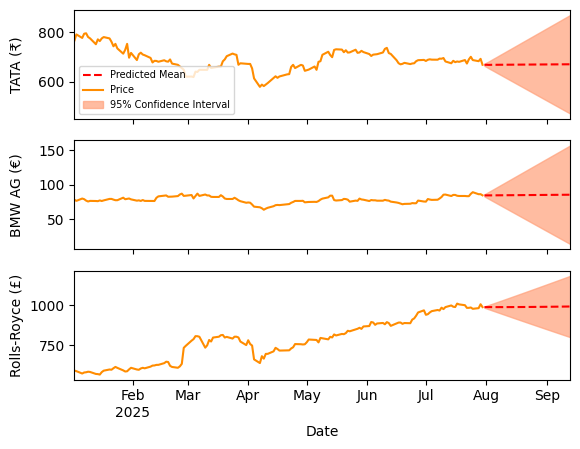

In [52]:
DAYS = 45
tata_pred = tata_model.forecast(steps=DAYS).reset_index()
bmw_pred = bmw_model.forecast(steps=DAYS).reset_index()
rrl_pred = rrl_model.forecast(steps=DAYS).reset_index()

tata_pred['Date'] = pandas.date_range(start=END, end=END+datetime.timedelta(days=DAYS-1))
bmw_pred['Date'] = pandas.date_range(start=END, end=END+datetime.timedelta(days=DAYS-1))
rrl_pred['Date'] = pandas.date_range(start=END, end=END+datetime.timedelta(days=DAYS-1))

tata_pred.set_index('Date', inplace=True)
bmw_pred.set_index('Date', inplace=True)
rrl_pred.set_index('Date', inplace=True)

tata_pred = tata_pred[['predicted_mean']]
bmw_pred = bmw_pred[['predicted_mean']]
rrl_pred = rrl_pred[['predicted_mean']]

tata_conf = tata_model.get_forecast(steps=DAYS).conf_int(alpha=0.05).reset_index()
bmw_conf = bmw_model.get_forecast(steps=DAYS).conf_int(alpha=0.05).reset_index()
rrl_conf = rrl_model.get_forecast(steps=DAYS).conf_int(alpha=0.05).reset_index()

tata_conf['Date'] = pandas.date_range(start=END, end=END+datetime.timedelta(days=DAYS-1))
bmw_conf['Date'] = pandas.date_range(start=END, end=END+datetime.timedelta(days=DAYS-1))
rrl_conf['Date'] = pandas.date_range(start=END, end=END+datetime.timedelta(days=DAYS-1))

tata_conf.set_index('Date', inplace=True)
bmw_conf.set_index('Date', inplace=True)
rrl_conf.set_index('Date', inplace=True)

fig, axs = plt.subplots(3, 1, sharex=True)
tata_sinh = numpy.sinh(tata_pred.copy())
tata_fin = tata_test.copy().reset_index()
tata_fin = tata_fin[tata_fin.Date == tata_fin.Date.max()]
tata_undiff = numpy.r_[tata_fin.Close, tata_pred.predicted_mean].cumsum()
tata_lower = numpy.r_[tata_fin.Close, tata_conf['lower Close']].cumsum()
tata_upper = numpy.r_[tata_fin.Close, tata_conf['upper Close']].cumsum()

_tata_pred = tata_pred.copy().reset_index()
_tata_pred['predicted_mean'] = tata_undiff[1:]
_tata_pred.rename(columns={'index':'Date'}, inplace=True)
_tata_pred.set_index('Date', inplace=True)
_tata_pred.plot(ax=axs[0], color='red', linestyle='dashed')

_tata_lower = tata_pred.copy().reset_index()
_tata_lower['ci_lower'] = tata_lower[1:]
_tata_lower.rename(columns={'index':'Date'}, inplace=True)
_tata_lower.set_index('Date', inplace=True)

_tata_upper = tata_pred.copy().reset_index()
_tata_upper['ci_upper'] = tata_upper[1:]
_tata_upper.rename(columns={'index':'Date'}, inplace=True)
_tata_upper.set_index('Date', inplace=True)

tata_test.plot(ax=axs[0], color='darkorange')
axs[0].fill_between(_tata_pred.index, _tata_lower['ci_lower'], _tata_upper['ci_upper'], color='lightsalmon', alpha=0.7)
axs[0].legend(['Predicted Mean', 'Price', '95% Confidence Interval'], fontsize=7)
axs[0].set_ylabel(f'TATA ({rupee})')

bmw_sinh = numpy.sinh(bmw_pred.copy())
bmw_fin = bmw_test.copy().reset_index()
bmw_fin = bmw_fin[bmw_fin.Date == bmw_fin.Date.max()]
bmw_undiff = numpy.r_[bmw_fin.Close, bmw_pred.predicted_mean].cumsum()
bmw_lower = numpy.r_[bmw_fin.Close, bmw_conf['lower Close']].cumsum()
bmw_upper = numpy.r_[bmw_fin.Close, bmw_conf['upper Close']].cumsum()

_bmw_pred = bmw_pred.copy().reset_index()
_bmw_pred['predicted_mean'] = bmw_undiff[1:]
_bmw_pred.rename(columns={'index':'Date'}, inplace=True)
_bmw_pred.set_index('Date', inplace=True)
_bmw_pred.plot(ax=axs[1], color='red', linestyle='dashed')

_bmw_lower = bmw_pred.copy().reset_index()
_bmw_lower['ci_lower'] = bmw_lower[1:]
_bmw_lower.rename(columns={'index':'Date'}, inplace=True)
_bmw_lower.set_index('Date', inplace=True)

_bmw_upper = bmw_pred.copy().reset_index()
_bmw_upper['ci_upper'] = bmw_upper[1:]
_bmw_upper.rename(columns={'index':'Date'}, inplace=True)
_bmw_upper.set_index('Date', inplace=True)

bmw_test.plot(ax=axs[1], color='darkorange')
axs[1].fill_between(_bmw_pred.index, _bmw_lower['ci_lower'], _bmw_upper['ci_upper'], color='lightsalmon', alpha=0.7)
axs[1].get_legend().set_visible(False)
axs[1].set_ylabel(f'BMW AG ({euro})')

rrl_sinh = numpy.sinh(rrl_pred.copy())
rrl_fin = rrl_test.copy().reset_index()
rrl_fin = rrl_fin[rrl_fin.Date == rrl_fin.Date.max()]
rrl_undiff = numpy.r_[rrl_fin.Close, rrl_pred.predicted_mean].cumsum()
rrl_lower = numpy.r_[rrl_fin.Close, rrl_conf['lower Close']].cumsum()
rrl_upper = numpy.r_[rrl_fin.Close, rrl_conf['upper Close']].cumsum()

_rrl_pred = rrl_pred.copy().reset_index()
_rrl_pred['predicted_mean'] = rrl_undiff[1:]
_rrl_pred.rename(columns={'index':'Date'}, inplace=True)
_rrl_pred.set_index('Date', inplace=True)
_rrl_pred.plot(ax=axs[2], color='red', linestyle='dashed')

_rrl_lower = rrl_pred.copy().reset_index()
_rrl_lower['ci_lower'] = rrl_lower[1:]
_rrl_lower.rename(columns={'index':'Date'}, inplace=True)
_rrl_lower.set_index('Date', inplace=True)

_rrl_upper = tata_pred.copy().reset_index()
_rrl_upper['ci_upper'] = rrl_upper[1:]
_rrl_upper.rename(columns={'index':'Date'}, inplace=True)
_rrl_upper.set_index('Date', inplace=True)

rrl_test.plot(ax=axs[2], color='darkorange')
axs[2].get_legend().set_visible(False)
axs[2].set_ylabel(f'Rolls-Royce (£)')
axs[2].fill_between(_bmw_pred.index, _rrl_lower['ci_lower'], _rrl_upper['ci_upper'], color='lightsalmon', alpha=0.7)

axs[0].minorticks_off()
axs[0].xaxis.set_major_locator(mdates.MonthLocator())
fig.align_ylabels(axs);